# Life history trade-offs: Antibiotic Resistance and Vaccination

for the entity of this simulation we will assume the same population size $N$ and the same starting conditions for $S_0$, $I_0$ and $R_0$. The rest of the parameters varies from case to case.

In [1]:
#imports

import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import ipywidgets
from ipywidgets import interact, interactive, interact_manual, fixed
import ipywidgets as widgets
from ipywidgets import FloatSlider, IntSlider
import pandas as pd
import plotly.express as px
import seaborn as sn

In [2]:
HOME_DIR = "/Users/martinemons/polybox/Universitaet/MSc_CBB/FS2021/IDD-rotation/IDD_TB"

The parameter values were taken from Lehtinen 2018 and Colijn 2009

## SIS model modelling antibiotic resistance

### Model and Analytical Solutions at Equilibrium

In order to model the trade-offs of transmissability and virulence, we first have to develop a model of antibiotic resistance. We do this with a SIS model. The reasoning behind choosing an SIS model is that we neglect immunity and births, since we believe that in the long term these two forces will cancel out so we make the simplifying assumption that we don't explicitly model it. We model one class of susceptibles and two classes of infected individuals, one being resistant and one being sensitive. The sensitive class can be treated with antibiotic, which we encode with a $\tau$ parameter.

The ODE system that describes this model is the following:

$$
\begin{aligned}
\frac{dS}{dt} &= (\gamma_s + \tau) I_s - \beta_s S I_s + \gamma_r I_r - \beta_r SI_r\\
\frac{dI_s}{dt} &= \beta_s S I_s - (\gamma_s + \tau) I_s\\
\frac{dI_r}{dt} &= \beta_r S I_r - \gamma_r I_r
\end{aligned}
$$

Since we assume that antibiotic resistance confers an advantage in clearing but a disadvantage in infecting (need to invest cost in resistance), $\beta_s > \beta_r$. This will be encoded via a cost term $c_{\beta}$ so we end up with $\beta_r = \frac{\beta}{c_{\beta}}$ and $\beta_s = \beta$. The same applies for the clearance rate, where $\gamma_r > \gamma_s$. This we model again with a clearance cost $c_{\gamma}$ and get $\gamma_r = c_{\gamma}\gamma$ and $\gamma_s = \gamma$

$$
\begin{aligned}
\frac{dS}{dt} &= (\gamma + \tau) I_s - \beta S I_s + c_{\gamma}\gamma I_r - \frac{\beta}{c_{\beta}}SI_r\\
\frac{dI_s}{dt} &= \beta S I_s - (\gamma + \tau) I_s\\
\frac{dI_r}{dt} &= \frac{\beta}{c_{\beta}}S I_r - c_{\gamma}\gamma I_r
\end{aligned}
$$

Since we neglect births and deaths as seen above we get a constant population size N: $ N = S + I_r + I_s$. This means the system becomes a 2x2 system of equations:

$$
\begin{aligned}
\frac{dI_s}{dt} &= \beta(N-I_s-I_r) I_s - (\gamma + \tau) I_s\\
\frac{dI_r}{dt} &= \frac{\beta}{c_{\beta}}(N-I_s-I_r)I_r - c_{\gamma}\gamma I_r
\end{aligned}
$$

Factoring out $I_r$ and $I_s$ we get:

$$
\begin{aligned}
\frac{dI_s}{dt} &= I_s \left(\beta(N-I_s-I_r) - (\gamma + \tau) \right) \stackrel{!}{=} 0\\
\frac{dI_r}{dt} &= I_r \left(\frac{\beta}{c_{\beta}}(N-I_s-I_r) - c_{\gamma}\gamma \right) \stackrel{!}{=} 0
\end{aligned}
$$

Here we get either a disease free solution ($I_s = I_r = 0$) or three endemic solutions

* disease free: $I_s = I_r = 0$

* endemic I: $I_s = I_r \neq 0$

$$
\begin{aligned}
N-I_s-I_r &= \frac{\gamma + \tau}{\beta}\\
N-I_s-I_r &= \frac{c_{\gamma}c_{\beta}\gamma}{\beta}
\end{aligned}
$$

It follows that $S = \frac{\gamma + \tau}{\beta} = \frac{c_{\gamma}c_{\beta}\gamma}{\beta}$

If we take the inverse of $S$ it follows that $\frac{\beta}{\gamma + \tau} = \frac{\beta}{c_{\gamma}c_{\beta}\gamma}$. This is the definition of $R_0$ meaning that we get the relationship $R_{0_s} = R_{0_r}$ at equilibrium.

* endemic II: $I_s = 0, I_r \neq 0$

$$
\begin{aligned}
\frac{dI_s}{dt} &= I_s \left(\beta(N-I_s-I_r) - (\gamma + \tau) \right) \stackrel{!}{=} 0\\
\frac{dI_r}{dt} &= I_r \left(\frac{\beta}{c_{\beta}}(N-I_s-I_r) - c_{\gamma}\gamma \right) \stackrel{!}{=} 0
\end{aligned}
$$

Since $I_s = 0$ we get: 

$$
\begin{aligned}
I_r \left(\frac{\beta}{c_{\beta}}(N-I_r)-c_{\gamma}\gamma\right) = 0\\
\end{aligned}
$$

since $I_r \neq 0$ the brackets need to zero:

$$
\begin{aligned}
\frac{\beta}{c_{\beta}}(N-I_r)-c_{\gamma}\gamma &= 0\\
\frac{\beta}{c_{\beta}}N - \frac{\beta}{c_{\beta}} I_r - c_{\gamma} \gamma &= 0\\
\frac{\beta}{c_{\beta}} I_r &=  \frac{\beta}{c_{\beta}}N - c_{\gamma} \gamma\\
I_r &= N - \frac{c_{\beta}c_{\gamma}\gamma}{\beta}
\end{aligned}
$$

* endemic III: $I_s \neq 0, I_r = 0$

$$
\begin{aligned}
\frac{dI_S}{dt} &= I_s \left(\beta(N-I_s-I_r) - (\gamma + \tau) \right) \stackrel{!}{=} 0\\
\frac{dI_R}{dt} &= I_r \left(\frac{\beta}{c_{\beta}}(N-I_s-I_r) - c_{\gamma}\gamma \right) \stackrel{!}{=} 0
\end{aligned}
$$

Since $I_r = 0$ we get:

$$
I_s \left(\beta(N-I_s) - (\gamma + \tau) \right) = 0
$$

since $I_s \neq 0$ the brackets need to zero:

$$
\begin{aligned}
\beta(N-I_s) - (\gamma + \tau)  &= 0\\
\beta N - \beta I_s - \gamma + \tau &= 0\\
\beta I_s &= \beta N - \gamma + \tau \\
I_s &= N - \frac{\gamma + \tau}{\beta}
\end{aligned}
$$


### Stability Analysis at Equilibrium

Stability analysis will allow us to decide which equilibrium will be attained according to the parameters. In this analysis we perform a linearisation of the system around the equilibrium point. First, we will define the Jacobian Matrix

$$
\begin{aligned}
\mathbb{J}  &= \begin{pmatrix} \frac{\partial f_1}{\partial I_s} & \frac{\partial f_1}{\partial I_r} \\ \frac{\partial f_2}{\partial I_s} & \frac{\partial f_2}{\partial I_r} \end{pmatrix}\\
            &= \begin{pmatrix} \beta(N-2I_s-I_r)-(\gamma+\tau) & -\beta I_s & \\ -\frac{\beta}{c_{\beta}}I_r & \frac{\beta}{c_{\beta}}(N-I_s-2I_r)-c_{\gamma}\gamma \end{pmatrix}\\
\end{aligned}
$$

the stability of the equilibrium point can be determined by the sign of the eigenvalues of the Jacobian. In order to solve this, we will have to define the characteristic polynomial:

$$
\begin{aligned}
\det(\mathbb{J}-\lambda \mathbb{I}) &= 0\\
\end{aligned}
$$

In order to solve this we will plug in the equilibrium solutions and then solving the resulting characteristic polynomial.

We will analyse it first generally and then plug in the corresponding values at the equilibria.

$$
\begin{aligned}
\det(\mathbb{J}-\lambda \mathbb{I}) &= 0\\
&= \begin{pmatrix} \beta(N-2I_s-I_r)-(\gamma+\tau) - \lambda & -\beta I_s \\  -\frac{\beta}{c_{\beta}}I_r& \frac{\beta}{c_{\beta}}(N-I_s-2I_r)-c_{\gamma}\gamma-\lambda \end{pmatrix} = 0\\
&= \left[\beta(N-2I_s-I_r)-(\gamma+\tau) - \lambda\right]\cdot\left[\frac{\beta}{c_{\beta}}(N-I_s-2I_r)-c_{\gamma}\gamma-\lambda\right] - \left[-\beta I_s\right] \cdot \left[-\frac{\beta}{c_{\beta}}I_r\right] = 0 \\
&= \lambda^2 + \lambda\left(c_{\gamma}\gamma - \frac{\beta}{c_{\beta}}(N-I_s-2I_r) + (\gamma + \tau)-\beta(N-2I_s-I_r)\right) + \frac{\beta^2}{c_{\beta}}(N-2I_s-I_r)(N-I_s-2I_r)-\beta c_{\gamma}\gamma (N-2I_s-I_r)\\&+c_{\gamma}\gamma(\gamma + \tau) - (\gamma + \tau)\frac{\beta}{c_{\beta}}(N-I_s-2I_r) - \frac{\beta^2}{c_{\beta}} I_r I_s
\end{aligned}
$$

this can then be solved using midnights formula:

$$
\lambda_{1,2} = \frac{-b \pm \sqrt{b^2-4ac}}{2a}
$$

The parameters $a,b,c$ for the different equilibrium points are:

* disease free ($I_s = I_r = 0$) :

$$
\begin{aligned}
a &= 1 \\
b &= \frac{\beta}{c_{\beta}}N + c_{\gamma}\gamma + \gamma + \tau - \beta N\\
c &= \frac{\beta^2}{c_{\beta}}N^2 - \beta c_{\gamma}\gamma N - \frac{\beta}{c_{\beta}} \gamma N + c_{\gamma}(\gamma + \tau) - \frac{\beta}{c_{\beta}}N (\tau + \gamma)\\
\end{aligned}
$$

* endemic I ($I_s \neq 0, I_r \neq 0$):

$$
\begin{aligned}
a &= 1 \\
b &= c_{\gamma}\gamma - \frac{\beta}{c_{\beta}}(N-I_s-2I_r) + (\gamma + \tau)-\beta(N-2I_s-I_r)\\
c &= \frac{\beta^2}{c_{\beta}}(N-2I_s-I_r)(N-I_s-2I_r)-\beta c_{\gamma}\gamma (N-2I_s-I_r)\\&+c_{\gamma}\gamma(\gamma + \tau) - (\gamma + \tau)\frac{\beta}{c_{\beta}}(N-I_s-2I_r) - \frac{\beta^2}{c_{\beta}} I_r I_s
\end{aligned}
$$

* endemic II ($I_s = 0, I_r \neq 0$):

$$
\begin{aligned}
a &= 1 \\
b &= c_{\gamma}\gamma - \frac{\beta}{c_{\beta}}(N-2I_r) + (\gamma + \tau)-\beta(N-I_r)\\
c &= \frac{\beta^2}{c_{\beta}}(N-I_r)(N-2I_r)-\beta c_{\gamma}\gamma (N-I_r)\\&+c_{\gamma}\gamma(\gamma + \tau) - (\gamma + \tau)\frac{\beta}{c_{\beta}}(N-2I_r) - \frac{\beta^2}{c_{\beta}}
\end{aligned}
$$

* endemic III ($I_s \neq 0, I_r = 0$):

$$
\begin{aligned}
a &= 1 \\
b &= c_{\gamma}\gamma - \frac{\beta}{c_{\beta}}(N-I_s) + (\gamma + \tau)-\beta(N-2I_s)\\
c &= \frac{\beta^2}{c_{\beta}}(N-2I_s)(N-I_s)-\beta c_{\gamma}\gamma (N-2I_s)\\&+c_{\gamma}\gamma(\gamma + \tau) - (\gamma + \tau)\frac{\beta}{c_{\beta}}(N-I_s) 
\end{aligned}
$$



In [285]:
#adding birth and death rates to the simple SIR model

#available population to infect

N = 1000

#prior infected susceptible and resistant
Is0, Ir0 = 1, 1

#prior susceptible
S0 = N - Is0 - Ir0

#parameters
beta = 2/N # why does frequency dependent beta make such a difference to density dependent?

#clearance rate
gamma = 1

#interval to plot
t = 500

#terms to be added because of resistance modelling
cg = 1.0
cb = 1.2
tau = 0.20999999999999996

In [287]:
#PRE: all variables are positive integers
#POST: The SIS model on antibiotic resistance

def SIS (t, y, N, beta, gamma, cg, cb, tau):
    S, Is, Ir = y
    dSdt = (gamma + tau) * Is - beta * S * Is + cg * gamma * Ir - beta/cb * S * Ir
    dIsdt = beta * S * Is - (gamma + tau) * Is
    dIrdt = beta / cb * S * Ir - cg * gamma * Ir

    return dSdt, dIsdt, dIrdt

### Solving the ODE system

In [289]:
#numerically integrate the ODEs
y0 = S0, Is0, Ir0
sol = solve_ivp(SIS, [0,t], y0, rtol=1e-6, method = 'RK23', dense_output = True, args=(N, beta, gamma, cg, cb, tau), max_step = 10000)

In [291]:
sol_df = pd.DataFrame(sol.y/1000)

In [293]:
sol_df

,0,1,2,3,4,5,6,7,8,9,...,300,301,302,303,304,305,306,307,308,309
0,0.998,0.997995,0.997948,0.997857,0.997762,0.997664,0.997562,0.997457,0.997348,0.997234,...,0.600179,0.600173,0.600167,0.600161,0.600155,0.600150,0.600144,0.600140,0.600134,0.600132
1,0.001,0.001003,0.001028,0.001078,0.001130,0.001183,0.001239,0.001297,0.001358,0.001421,...,0.011854,0.011433,0.011027,0.010634,0.010255,0.009889,0.009536,0.009195,0.008865,0.008697
2,0.001,0.001002,0.001024,0.001065,0.001108,0.001153,0.001198,0.001246,0.001295,0.001345,...,0.387967,0.388394,0.388806,0.389204,0.389590,0.389961,0.390320,0.390666,0.391001,0.391171


### Plotting the results


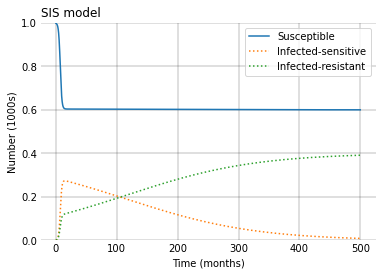

In [294]:
#plot
fig = plt.figure()
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(sol.t, sol_df.iloc[0][:], linestyle = '-', label = 'Susceptible')
ax.plot(sol.t, sol_df.iloc[1][:], linestyle = ':', label = 'Infected-sensitive')
ax.plot(sol.t, sol_df.iloc[2][:], linestyle = ':', label = 'Infected-resistant')
ax.legend()
#ax.legend(curves, ['Susceptible', 'Infected-sensitive', 'Infected-resistant'])
ax.set_xlabel('Time (months)')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.0)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='k', lw=0.25, ls='-')
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.title('SIS model', loc='left')
plt.show()

### Interactive plotting tool

In [295]:
#numerically integrate the ODEs
def interactive_plot(y0, t, N, beta, gamma, cg, cb, tau, V):
    #defining the susceptibles for the model - will reduce the number of available hosts by introducing more vaccinated hosts
    S0 = N - V - Is0 - Ir0
    y0 = S0, Is0, Ir0
    #solve the SIS numerically
    sol = solve_ivp(SIS, [0,t], y0, method = 'RK23', dense_output = True, args=(N, beta, gamma, cg, cb, tau))
    #plot the results
    fig = plt.figure()
    ax = fig.add_subplot(111,  axisbelow=True)
    curves = ax.plot(sol.t, sol.y.T/1000)
    ax.legend(curves, ['Susceptible', 'Infected-sensitive', 'Infected-resistant'])
    ax.set_xlabel('Time (months)')
    ax.set_ylabel('Number (1000s)')
    ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='k', lw=0.25, ls='-')
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.title('SIS model', loc='left')
    plt.show()

In [296]:
interact(interactive_plot, y0 = fixed(y0) , t = fixed(t), N = fixed(N), beta = widgets.FloatSlider(min=0.1/N, max=4/N, step=0.1/N, value=beta), gamma = widgets.FloatSlider(min=0.1, max=1, step=0.1, value=gamma), cg = (cg), cb = (cb) , tau = widgets.FloatSlider(min=0.05, max=1, step=0.05, value=tau), V = widgets.IntSlider(min=0, max=N, step=10, value=0))

interactive(children=(FloatSlider(value=0.002, description='beta', max=0.004, min=0.0001, step=0.0001), FloatS…

<function __main__.interactive_plot(y0, t, N, beta, gamma, cg, cb, tau, V)>

### Analysis of initial growth

We can analyse the initial growth of the system as follows
$$
\begin{aligned}
\frac{dS}{dt} &= (\gamma + \tau) I_s - \beta S I_s + c_{\gamma}\gamma I_r - \frac{\beta}{c_{\beta}}SI_r\\
\frac{dI_s}{dt} &= \beta S I_s - (\gamma + \tau) I_s\\
\frac{dI_r}{dt} &= \frac{\beta}{c_{\beta}}S I_r - c_{\gamma}\gamma I_r
\end{aligned}
$$

We plug in the initial conditions of the disease free state

if $I_s$ should grow faster than $I_r$ we get the following

$$
\beta S_{df} - (\gamma + \tau) > \frac{\beta}{c_{\beta}} S_{df}-c_{\gamma}\gamma
$$

as $S_{df} = C$ in the disease-free state we get

$$
\begin{aligned}
\beta S_{df} - \frac{\beta}{c_{\beta}}S_{df}-\gamma - \tau + c_{\gamma}\gamma &>0\\
\beta S_{df} \left(1-\frac{1}{c_\beta}\right) + \gamma (c_\gamma - 1) - \tau &> 0
\end{aligned}
$$

This means we only suspect a faster growth of $I_s$ in the beginning (dominance) if the above holds true. This is the case e.g. when $c_{\gamma} = c_{\beta} \geq 1$. If only one of them is greater than $1$, then the inequality above has to hold.


### Phase plot of the system

For the phase plot we simplify the system. Since we neglect births and deaths as seen above we get a constant population size N: $ N = S + I_R + I_S$. This means the system becomes a 2x2 system of equation:

$$
\begin{aligned}
\frac{dI_S}{dt} &= \beta(N-I_S-I_R) I_S - (\gamma + \tau) I_S\\
\frac{dI_R}{dt} &= \frac{\beta}{c_{\beta}}(N-I_S-I_R)I_R - c_{\gamma}\gamma I_R
\end{aligned}
$$

This simplified system can be solved in a phase plane analysis as seen below for varrying initial conditions of $I_S$ and $I_R$.

In [297]:
#PRE: all variables are positive integers
#POST: The simplified SIS model on antibiotic resistance

def SISsimplified (y,t,N,beta,gamma,cg,cb,tau):
    Is, Ir = y
    dIsdt = beta * (N-Is-Ir) * Is - (gamma + tau) * Is
    dIrdt = beta / cb * (N-Is-Ir) * Ir - cg * gamma * Ir

    return dIsdt, dIrdt

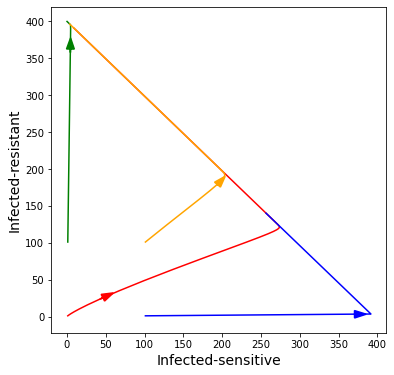

In [321]:
y0 = Is0, Ir0
ts = np.linspace(0, 500, 700)

fig = plt.figure()
fig.set_size_inches(6,6)
ics = np.arange(1.0, 200, 100)# initial conditions

colors = ["red", "blue" , "green", "orange"]
ncolor = 0
for r in ics:
    for s in ics:
        y0 = s, r
            #sol2 = solve_ivp(SISsimplified, 0,t], y0, method = 'RK23', dense_output = True, args=(N, beta,     gamma, cg, cb, tau))
        sol2 = odeint (SISsimplified, y0, ts, args= (N, beta,  gamma, cg, cb, tau))
        plt.plot(sol2[:,0],sol2[:,1], "-", color = colors[ncolor])
      
        plt.arrow(sol2[7,0], sol2[7,1], sol2[7,0]-sol2[6,0] ,sol2[7,1]-sol2[6,1], shape='full', lw=1.5, length_includes_head=True, head_width=10, color = colors[ncolor])
        ncolor += 1
plt.xlabel("Infected-sensitive", fontsize=14)
plt.ylabel("Infected-resistant", fontsize=14)
plt.show()

### Parametrisation effect  via Riemann Sum

in order to quantify the effect the choice of parameters has, I calculate the riemann sum for different values of $\beta$

In [299]:
sol_df = pd.DataFrame(sol.y)

In [300]:
sol_df.loc[1,:].sum()

31704.408432664677

In [301]:
y0 = S0, Is0, Ir0
data = []
#perform parameter analysis for cg
for i in np.arange(0.1, 2, 0.1):
    sol = solve_ivp(SIS, [0,t], y0, method = 'RK23', dense_output = True, args=(N, beta, gamma, i, cb, tau))
    sol_df = pd.DataFrame(sol.y/N)
    data.append(sol_df.loc[1,:].sum())
#perform parameter analysis for cb
data2 = []
for i in np.arange(0.1, 2, 0.1):
    sol = solve_ivp(SIS, [0,t], y0, method = 'RK23', dense_output = True, args=(N, beta, gamma, cg, i, tau))
    sol_df = pd.DataFrame(sol.y/N)
    data2.append(sol_df.loc[1,:].sum())

In [302]:
data_df = pd.DataFrame(data)

In [303]:
data_df['cb'] = data2

In [304]:
# hard coded renaming - should be improved but works for now
data_df = data_df.rename(columns={0:'cg', 'cb':'cb'}, index={0:0, 1: 0.1, 2: 0.2, 3:0.3, 4:0.4, 5: 0.5, 6: 0.6, 7: 0.7, 8: 0.8, 9: 0.9, 10: 1, 11: 1.1, 12: 1.2, 13: 1.3, 14: 1.4, 15: 1.5, 16: 1.6, 17: 1.7, 18:1.8})

In [305]:
data_df

,cg,cb
0.0,0.135680,0.034064
0.1,0.158437,0.034608
0.2,0.190116,0.037585
0.3,0.235678,0.045171
0.4,0.302873,0.056772
0.5,0.411437,0.075490
0.6,0.595835,0.108798
0.7,0.890854,0.171336
0.8,1.620996,0.306128
0.9,15.961816,0.601067


In [306]:
fig = px.scatter(data_df, labels=dict(index='cost', value='Riemann Sum'), title="Riemann Sum for Different cost values")
fig

In [307]:
pd.DataFrame(solve_ivp(SIS, [0,t], y0, method = 'RK23', dense_output = True, args=(N, 0.1/N, gamma, cg, cb, tau)).y)

,0,1,2,3,4,5,6,7,8,9,...,230,231,232,233,234,235,236,237,238,239
0,998.0,998.045384,998.446076,998.932133,999.286463,999.525898,999.685107,999.790676,999.860712,999.907236,...,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
1,1.0,0.975168,0.758206,0.501709,0.321324,0.204158,0.129432,0.081991,0.051907,0.032837,...,-2.531724e-06,2.531724e-06,-2.531724e-06,2.531724e-06,-2.531724e-06,2.531724e-06,-2.531724e-06,2.531724e-06,-2.531724e-06,-3.659281e-08
2,1.0,0.979448,0.795717,0.566158,0.392213,0.269944,0.185461,0.127333,0.087381,0.059928,...,-3.567607e-84,1.467404e-84,-6.035624e-85,2.482532e-85,-1.021098e-85,4.199910e-86,-1.727478e-86,7.105344e-87,-2.922521e-87,-5.221717e-88


In [308]:
pd.DataFrame(solve_ivp(SIS, [0,t], y0, method = 'RK23', dense_output = True, args=(N, 4/N, gamma, cg, cb, tau)).y)

,0,1,2,3,4,5,6,7,8,9,...,498,499,500,501,502,503,504,505,506,507
0,998.0,997.936393,997.177948,995.993338,994.297585,991.871064,988.390267,983.380587,976.137906,965.599136,...,299.448401,300.712638,299.446803,300.711016,299.445237,300.709426,299.443701,300.707867,299.442196,300.035442
1,1.0,1.034682,1.454149,2.126519,3.114745,4.565396,6.698240,9.841791,14.492142,21.410782,...,18.507993,18.277251,18.127778,17.901630,17.755091,17.533452,17.389795,17.172581,17.031754,16.908786
2,1.0,1.028924,1.367903,1.880144,2.587670,3.563540,4.911493,6.777622,9.369952,12.990081,...,682.043607,681.010111,682.425419,681.387354,682.799672,681.757122,683.166504,682.119552,683.526050,683.055772


In [309]:
(pd.DataFrame(solve_ivp(SIS, [0,t], y0, method = 'RK23', dense_output = True, args=(N, 8/N, gamma, cg, cb, tau)).y)/1000).loc[1,:].sum()

307.89414031891005

In [310]:
y0 = S0, Is0, Ir0
data = pd.DataFrame(np.nan, index = np.arange(0, 26, 1), columns = np.arange(0, 26, 1))
#perform parameter analysis for cg and cb combined
for i in range(1, 26, 1):
    for j in range(1, 26, 1):
        sol = solve_ivp(SIS, [0,t], y0, method = 'RK23', dense_output = True, args=(N, beta, gamma, i/10, j/10, tau))
        sol_df = pd.DataFrame(sol.y/N)
        data.iloc[i,j] = sol_df.loc[1,:].sum()


In [311]:
#drop the first ten values as costs below 1 are not considered costs
for i in range(10):
    data = data.drop(data.iloc[0].name)
    data = data.drop(data.columns[0], axis=1 )

In [312]:
data = data.rename(columns={10: 1, 11: 1.1, 12: 1.2, 13: 1.3, 14: 1.4, 15: 1.5, 16: 1.6, 17: 1.7, 18:1.8, 19 : 1.9, 20:2, 21:2.1, 22: 2.2, 23:2.3, 24:2.4, 25:2.5}, index={10: 1, 11: 1.1, 12: 1.2, 13: 1.3, 14: 1.4, 15: 1.5, 16: 1.6, 17: 1.7, 18:1.8, 19 : 1.9, 20:2, 21:2.1, 22: 2.2, 23:2.3, 24:2.4, 25:2.5})

In [313]:
data

,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5
1.0,0.601067,1.449222,15.961816,62.322307,62.592536,60.650278,58.300841,57.915442,61.876103,62.672368,63.075134,63.463514,63.846195,63.862535,62.680585,63.470384
1.1,1.064554,37.855308,62.306722,62.583428,59.066454,60.668931,61.863290,61.480362,63.068928,63.853630,64.246147,63.857956,63.466688,63.859784,63.465594,63.853179
1.2,9.123024,62.166322,60.580913,60.267035,60.663990,60.678851,62.663678,64.246100,64.237602,63.863937,63.862100,63.859857,63.460369,63.845055,63.832426,63.814180
1.3,61.733004,59.733280,60.640074,61.842296,63.438463,62.265917,64.235418,63.465113,63.074772,63.468732,63.069030,63.447643,63.820609,63.797259,62.586667,65.717961
1.4,60.743743,60.997166,62.227673,63.826558,63.839545,64.212299,63.459409,63.854549,64.243513,63.450743,64.216896,65.767297,68.498616,70.041246,71.599723,73.120764
1.5,60.926743,63.412265,64.605813,63.830985,64.603867,64.246505,64.238528,63.846265,65.000939,68.936037,71.260564,74.009814,75.517819,77.812193,79.316322,80.821695
1.6,62.968200,64.200477,64.214722,64.981911,63.440572,65.401663,68.556595,70.919380,74.818134,77.170866,79.065590,81.352436,83.235288,85.107395,86.194790,88.077061
1.7,64.983704,64.993612,64.980491,64.611365,68.939227,72.487871,75.619784,78.355598,81.466548,84.893632,86.762789,88.641581,90.509486,91.967464,93.442221,95.729049
1.8,63.799538,65.001809,63.803974,70.924984,75.254897,79.139826,83.435509,86.133269,89.178644,91.783356,94.038821,96.296262,98.532020,100.008240,101.503219,102.991800
1.9,64.980556,66.936259,72.499994,76.863874,82.723976,86.270063,90.417179,93.070736,96.821037,99.070364,101.693282,103.924790,105.788290,107.260032,108.741480,110.629151


[Text(0.5, 15.0, 'c beta'),
 Text(33.0, 0.5, 'c gamma'),
 Text(0.5, 1.0, 'Riemann Sum of Sensitive Curve for Different Cost combinations')]

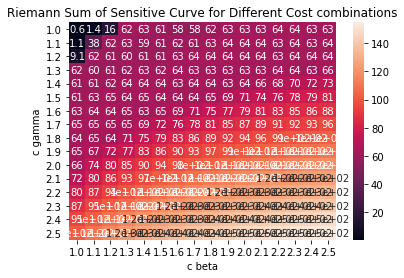

In [314]:
ax = sn.heatmap(data, annot=True)
ax.set(xlabel='c beta', ylabel='c gamma', title='Riemann Sum of Sensitive Curve for Different Cost combinations')